In [1]:
from src.hyperparameter_tuner import *
from src.model_evaluation import *
from src.viz_and_model_analysis import *

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline

from imblearn.over_sampling import ADASYN, SMOTE

import catboost as cb
import lightgbm as lgb
import xgboost as xgb

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


import pandas as pd

custom_palette = {
    'Fraud': '#c53b53',
    'Non-Fraud': '#394b70'
}
sns.color_palette(list(custom_palette.values()))

[(0.7725490196078432, 0.23137254901960785, 0.3254901960784314),
 (0.2235294117647059, 0.29411764705882354, 0.4392156862745098)]

In [4]:
df = pd.read_csv('data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df.isnull().sum().max()

np.int64(0)

In [7]:
df.duplicated().sum().max()

np.int64(1081)

In [8]:
duplicadas = df[df.duplicated()]

duplicadas.groupby(list(df.columns)).size().reset_index(name='count').query('count > 1')
duplicadas.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
33,26.0,-0.529912,0.873892,1.347247,0.145457,0.414209,0.100223,0.711206,0.176066,-0.286717,...,0.046949,0.208105,-0.185548,0.001031,0.098816,-0.552904,-0.073288,0.023307,6.14,0
35,26.0,-0.535388,0.865268,1.351076,0.147575,0.433680,0.086983,0.693039,0.179742,-0.285642,...,0.049526,0.206537,-0.187108,0.000753,0.098117,-0.553471,-0.078306,0.025427,1.77,0
113,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
114,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0
115,74.0,1.038370,0.127486,0.184456,1.109950,0.441699,0.945283,-0.036715,0.350995,0.118950,...,0.102520,0.605089,0.023092,-0.626463,0.479120,-0.166937,0.081247,0.001192,1.18,0


In [9]:
# df = df.drop_duplicates()

In [10]:
class_label = {
    0: 'Non-Fraud', 
    1: 'Fraud'
}

df['Class_label'] = df['Class'].map(class_label)

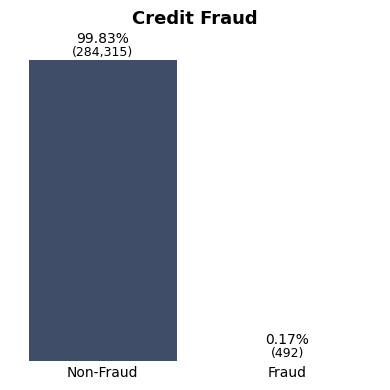

In [11]:
category_col='Class_label'

visualizer = DataVisualizer(
    dataframe=df, 
    figsize=(4, 4), 
    title = f'Credit Fraud'
    )

visualizer.plot_categorical_distribution(
    category_col=category_col, 
    palette = custom_palette
    )

In [12]:
df['Amount_log'] = np.log1p(df['Amount'])

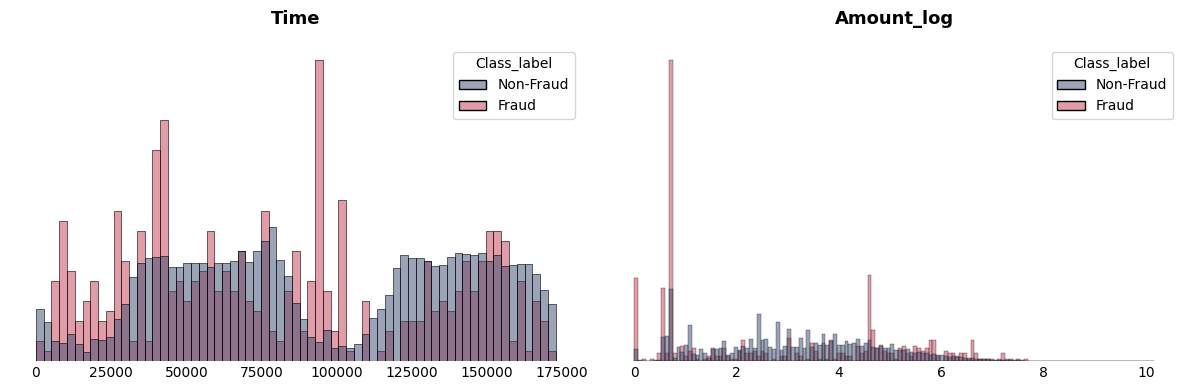

In [13]:
visualizer = DataVisualizer(
    dataframe=df, 
    figsize=(12, 4), 
    # title = f'Credit Fraud'
    )

visualizer.plot_feature_histograms(
    feature_cols=['Time', 'Amount_log'],
    group_col = 'Class_label',
    palette = custom_palette,
    common_norm=False,
    stat='density',
    # kde=True,
)

In [14]:
robust_scaler = RobustScaler()

df['scaled_amount'] = robust_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = robust_scaler.fit_transform(df['Time'].values.reshape(-1,1))

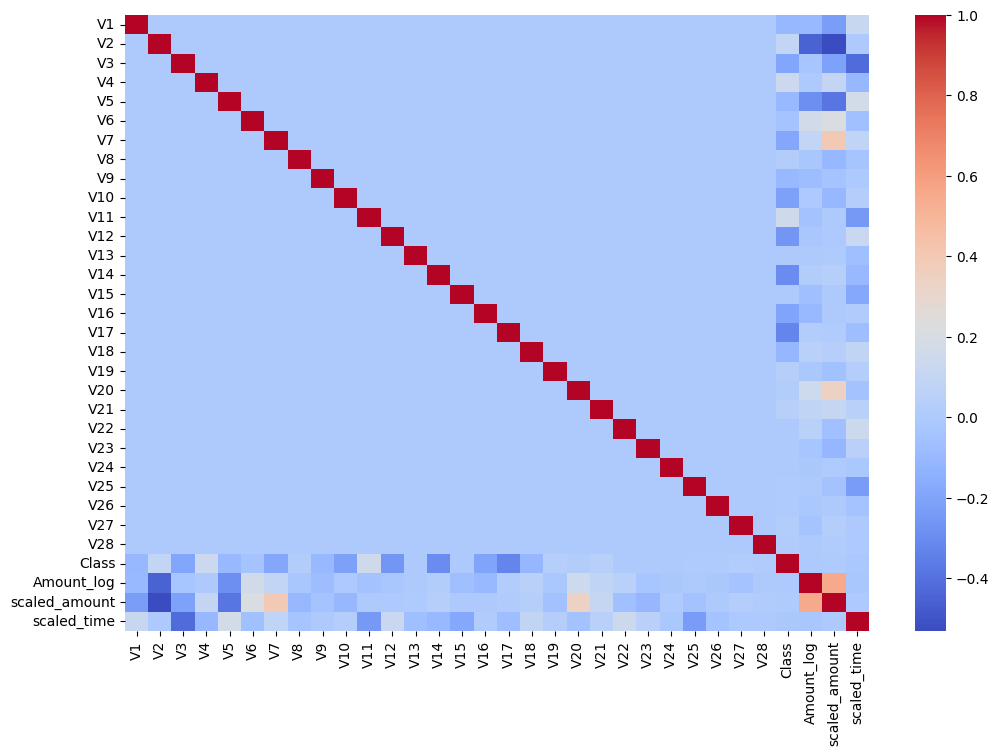

In [15]:
df_corr = df.drop(['Class_label', 'Time', 'Amount'], axis=1)

plt.figure(figsize=(12, 8)) 
corr = df_corr.corr()
sns.heatmap(corr, cmap='coolwarm')

plt.show()

In [16]:
corr['Class'][corr['Class'] < -0.13]

V3    -0.192961
V7    -0.187257
V10   -0.216883
V12   -0.260593
V14   -0.302544
V16   -0.196539
V17   -0.326481
Name: Class, dtype: float64

In [17]:
corr['Class'][corr['Class'] > 0.13]

V4       0.133447
V11      0.154876
Class    1.000000
Name: Class, dtype: float64

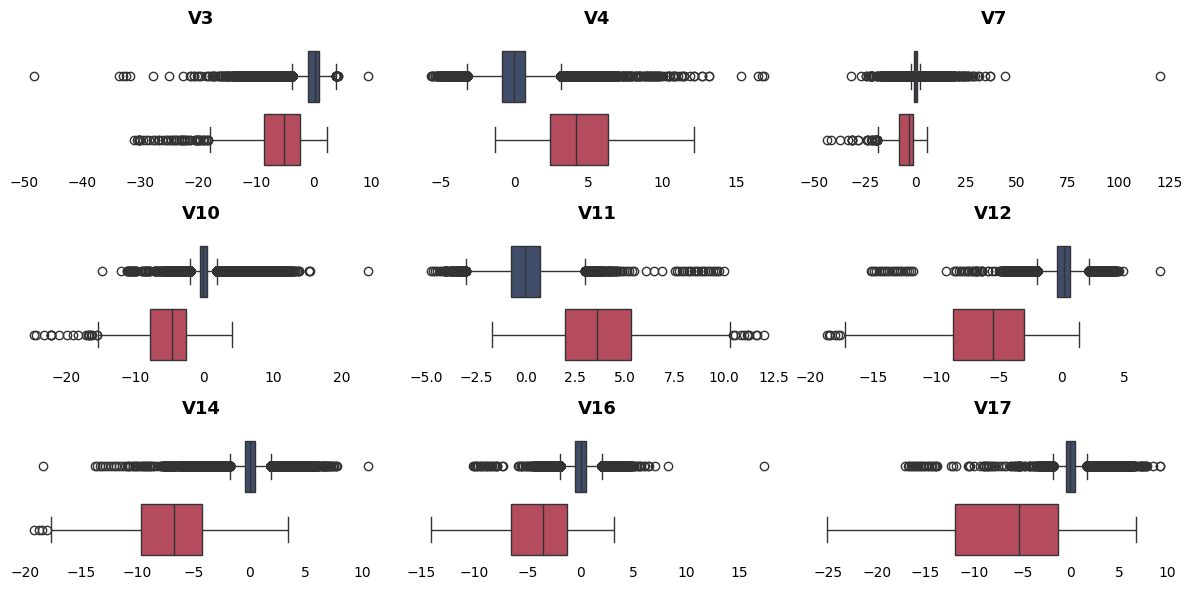

In [18]:
visualizer = DataVisualizer(
    dataframe=df, 
    figsize=(12, 6), 
    # title = f'Credit Fraud'
    )

visualizer.plot_feature_boxplots(
    feature_cols=['V3', 'V4','V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'],
    group_col = 'Class_label',
    palette = custom_palette,
)

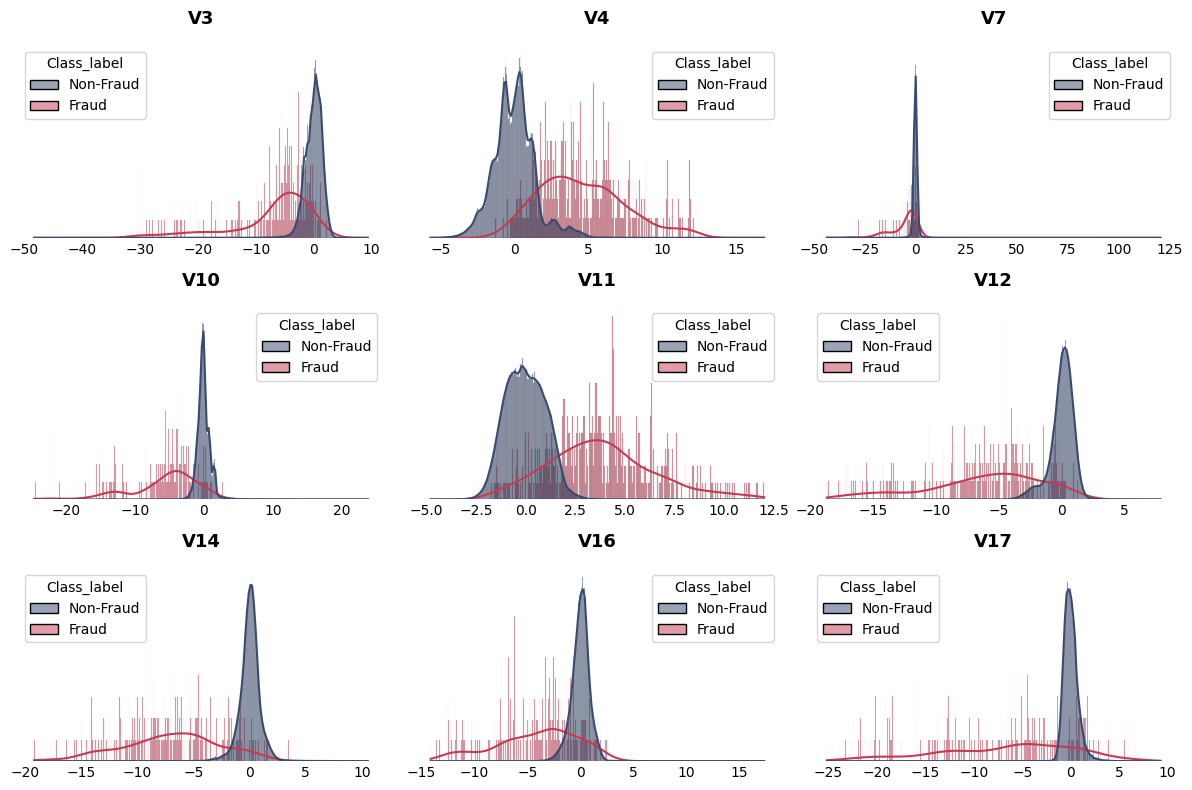

In [19]:
visualizer = DataVisualizer(
    dataframe=df, 
    figsize=(12, 8), 
    # title = f'Credit Fraud'
    )

visualizer.plot_feature_histograms(
    feature_cols=['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'],
    group_col = 'Class_label',
    palette = custom_palette,
    common_norm=False,
    stat='density',
    kde=True,
)

In [20]:
X = df.drop(['Class', 'Class_label'], axis=1)
y = df['Class']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:

# pipeline_xgb_smote = Pipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('xgb', xgb.XGBClassifier())
# ])

# pipeline_xgb_adasyn = Pipeline([
#     ('adasyn', ADASYN(random_state=42)),
#     ('xgb', xgb.XGBClassifier())
# ])


# pipeline_rf_smote = Pipeline([
#     ('smote', SMOTE(random_state=42)),
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
# ])

# pipeline_rf_adasyn = Pipeline([
#     ('adasyn', ADASYN(random_state=42)),
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
# ])


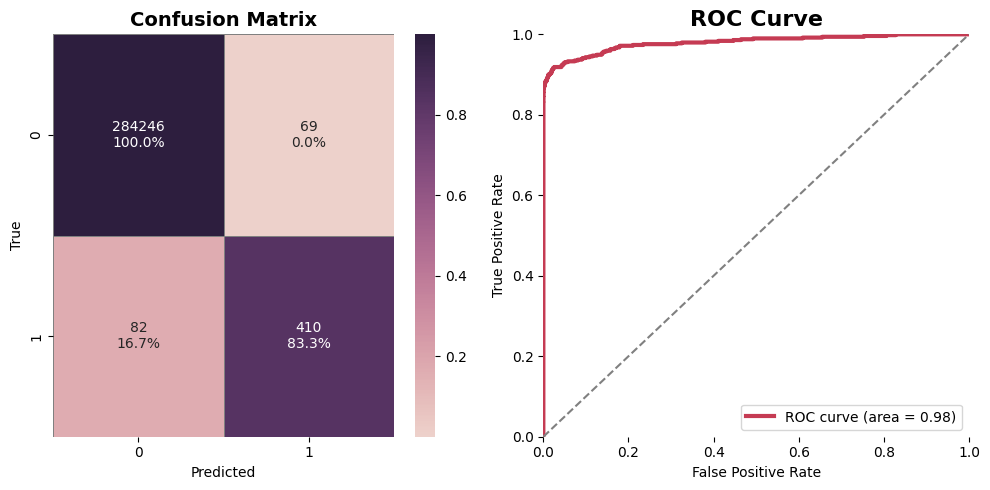

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Matthews Corrcoef,Cohen Kappa,Log Loss
0,99.95,99.95,99.95,99.95,97.99,0.85,0.84,0.34


In [23]:
pipeline_xgb = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb.XGBClassifier())
])

train_xgb = ClassificationValidator(model=pipeline_xgb, plot_cm=True, plot_roc=True)

cross_validation_scores_xgb = train_xgb.cross_validate(X=X, y=y)
cross_validation_scores_xgb

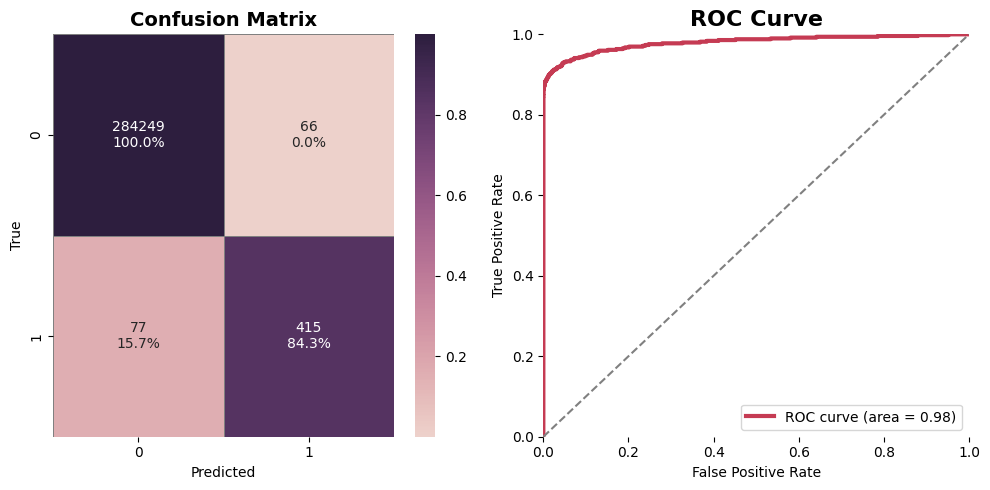

,Accuracy,Precision,Recall,F1 Score,ROC AUC,Matthews Corrcoef,Cohen Kappa,Log Loss
0,99.95,99.95,99.95,99.95,97.96,0.85,0.85,0.34


In [24]:
pipeline_xgb = Pipeline([
    ('ADASYN', ADASYN(random_state=42)),
    ('xgb', xgb.XGBClassifier())
])

train_xgb = ClassificationValidator(model=pipeline_xgb, plot_cm=True, plot_roc=True)

cross_validation_scores_xgb = train_xgb.cross_validate(X=X, y=y)
cross_validation_scores_xgb

In [ ]:
tuner = ClassificationHyperTuner(
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test,
    y_test=y_test, 
    model_name='xgb', 
    use_cv=True, 
    use_smote=True,
    n_trials=20
)

best_params_xgb, best_value_xgb = tuner.run_optimization()

[I 2025-04-17 19:40:09,131] A new study created in memory with name: no-name-1d90bed0-98c5-4bc2-8155-226e72f88e94


In [ ]:
best_params_xgb